In [2]:
import h5py
import numpy as np
import pandas as pd
import dask.array as da

# Path to your .h5 data file
data_path = "C:\\Users\\User\\OneDrive - University of Bristol\\Data Sci MSc\\Summer Project\\organised_data_new.h5"

# List to collect DataFrames per run for concatenation
dfs = []
ambler_start = 29
ambler_end = 287


with h5py.File(data_path, "r") as f:
    for enzyme in f.keys():
        if f[enzyme].attrs["carbapenemase"] == 1:
            
            # Load sequence and compute residue count
            seq = list(f[enzyme].attrs["sequence"])
            n_res = len(seq)

            # Precompute native mask for selection
            aa_order = "ACDEFGHIKLMNPQRSTVWY"
            native_idx = np.array([aa_order.index(aa) for aa in seq])
            native_mask = np.zeros((20, n_res), dtype=float)
            native_mask[native_idx, np.arange(n_res)] = 1.0
            native_letters = np.array(seq)

            for run_group in f[enzyme].keys():
                # Load as Dask array: (n_frames, 20, n_res)
                ds = f[enzyme][run_group]["probs"]
                probs_ds = da.from_array(ds, chunks=(1000, 20, n_res))

                ambler_idx = f[enzyme][run_group]["ambler_idx"][:]  # shape (n_res,)
                ins_rank   = f[enzyme][run_group]["ambler_ins_rank"][:]

                mask = (ambler_idx >= ambler_start) & (ambler_idx <= ambler_end) & (ins_rank == 0)

                # Compute full run probabilities to NumPy for sorting
                probs_np = probs_ds.compute()  # shape (n_frames, 20, n_res)
                n_frames = probs_np.shape[0]

                # --- new block to add most‐probable AA ---
                chosen_idx = probs_np.argmax(axis=1)     # (n_frames,n_res)
                aa_order = np.array(list("ACDEFGHIKLMNPQRSTVWY"))
                chosen_flat = aa_order[chosen_idx.ravel()]  # (n_frames*n_res,)

                # native letters flattened
                native_flat = np.tile(native_letters, n_frames)
                is_correct = (chosen_flat == native_flat).astype(int)               

                # Vectorized feature computations on NumPy array
                # native probability per frame/residue
                native_p = np.sum(probs_np * native_mask[np.newaxis, :, :], axis=1)  # (n_frames, n_res)
                # entropy per frame/residue
                entropy = -np.sum(probs_np * np.log(probs_np + 1e-9), axis=1)  # (n_frames, n_res)
                # gap between max and second max per residue
                sorted_p = np.sort(probs_np, axis=1)[:, ::-1, :]  # (n_frames, 20, n_res)
                gap = sorted_p[:, 0, :] - sorted_p[:, 1, :]  # (n_frames, n_res)

                # # Build a MultiIndex for flattening
                # index = pd.MultiIndex.from_product(
                #     [[enzyme], [enzyme_class], [run_group], np.arange(n_frames), np.arange(n_res)],
                #     names=["enzyme", "enzyme_class", "run", "frame", "residue_idx"]
                # )

                frame_idx   = np.repeat(np.arange(n_frames), n_res)
                raw_idx     = np.tile(np.arange(n_res), n_frames)
                ambler_idx_f = np.tile(ambler_idx, n_frames)

                # Stack feature arrays into shape (n_frames*n_res, 3)
                data = np.stack([
                    native_p.ravel(),
                    entropy.ravel(),
                    gap.ravel(),
                    is_correct.ravel()
                ], axis=1)

                # # Create DataFrame for this run and collect
                # df_run = pd.DataFrame(
                #     data,
                #     index=index,
                #     columns=["native_p", "entropy", "max_minus_second"]
                # ).reset_index()
                # dfs.append(df_run)

                df_run = pd.DataFrame(
                data,
                columns=["native_p", "entropy", "max_minus_second", "is_correct"]
                )
                df_run["enzyme"]        = enzyme
                df_run["run"]           = run_group
                df_run["frame"]         = frame_idx
                df_run["residue_idx"]   = raw_idx
                df_run["ambler_idx"] = ambler_idx_f
                df_run["chosen_aa"]   = chosen_flat
                df_run["native_aa"]     = native_flat
                dfs.append(df_run)

# Concatenate all runs into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

In [1]:
import h5py
import numpy as np
import pandas as pd
import dask.array as da

# Path to your .h5 data file
data_path = "C:\\Users\\User\\OneDrive - University of Bristol\\Data Sci MSc\\Summer Project\\organised_data_new.h5"

# List to collect DataFrames per run for concatenation
dfs = []
ambler_start = 29
ambler_end = 287


with h5py.File(data_path, "r") as f:
    for enzyme in f.keys():
        if f[enzyme].attrs["carbapenemase"] == 1:
            
            # Load sequence and compute residue count
            seq = list(f[enzyme].attrs["sequence"])
            n_res = len(seq)

            # Precompute native mask for selection
            aa_order = "ACDEFGHIKLMNPQRSTVWY"
            native_idx = np.array([aa_order.index(aa) for aa in seq])
            native_mask = np.zeros((20, n_res), dtype=float)
            native_mask[native_idx, np.arange(n_res)] = 1.0
            native_letters = np.array(seq)

            for run_group in f[enzyme].keys():
                # Load as Dask array: (n_frames, 20, n_res)
                ds = f[enzyme][run_group]["probs"]
                probs_ds = da.from_array(ds, chunks=(1000, 20, n_res))

                ambler_idx = f[enzyme][run_group]["ambler_idx"][:]      # (n_res,)
                ins_rank   = f[enzyme][run_group]["ambler_ins_rank"][:] # (n_res,)

                # keep canonical-only within window
                mask = (ambler_idx >= ambler_start) & (ambler_idx <= ambler_end) & (ins_rank == 0)
                if not np.any(mask):
                    continue

                keep_idx        = np.where(mask)[0]                # indices you keep
                ambler_idx_keep = ambler_idx[keep_idx]             # (n_keep,)
                native_letters_keep = native_letters[keep_idx]     # (n_keep,)
                native_mask_keep    = native_mask[:, keep_idx]     # (20, n_keep)

                # Load probs only for kept positions  → (n_frames, 20, n_keep)
                probs_ds = da.from_array(ds[:, :, keep_idx], chunks=(1000, 20, len(keep_idx)))
                probs_np = probs_ds.compute()
                n_frames, _, n_keep = probs_np.shape

                # Most-probable AA and features on the *kept* positions
                chosen_idx  = probs_np.argmax(axis=1)                # (n_frames, n_keep)
                aa_order    = np.array(list("ACDEFGHIKLMNPQRSTVWY"))
                chosen_flat = aa_order[chosen_idx.ravel()]           # (n_frames*n_keep,)

                native_flat = np.tile(native_letters_keep, n_frames)
                is_correct  = (chosen_flat == native_flat).astype(int)

                native_p = np.sum(probs_np * native_mask_keep[np.newaxis, :, :], axis=1)  # (n_frames, n_keep)
                entropy  = -np.sum(probs_np * np.log(probs_np + 1e-9), axis=1)
                sorted_p = np.sort(probs_np, axis=1)[:, ::-1, :]
                gap      = sorted_p[:, 0, :] - sorted_p[:, 1, :]

                # Flatten helpers use n_keep and (optionally) the kept raw indices
                frame_idx      = np.repeat(np.arange(n_frames), n_keep)
                raw_idx_kept   = np.tile(keep_idx, n_frames)         # original residue indices (optional)
                ambler_idx_f   = np.tile(ambler_idx_keep, n_frames)  # filtered ambler bases

                df_run = pd.DataFrame(
                    np.stack([native_p.ravel(), entropy.ravel(), gap.ravel(), is_correct.ravel()], axis=1),
                    columns=["native_p", "entropy", "max_minus_second", "is_correct"]
                )
                df_run["enzyme"]      = enzyme
                df_run["run"]         = run_group
                df_run["frame"]       = frame_idx
                df_run["residue_idx"] = raw_idx_kept                 # or reindex 0..n_keep-1 if you prefer
                df_run["ambler_idx"]  = ambler_idx_f
                df_run["chosen_aa"]   = chosen_flat
                df_run["native_aa"]   = native_flat
                dfs.append(df_run)


# Concatenate all runs into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

In [ ]:
enzymes = df['enzyme'].unique()

# 1. Per-residue (ambler_idx) summary metrics
res_stats = (
    df.groupby(['enzyme', 'ambler_idx'])
      .agg(
        mean_Pnat     = ('native_p','mean'),
        std_Pnat      = ('native_p','std'),
        mean_ent      = ('entropy','mean'),
        std_ent       = ('entropy','std'),
        mean_gap      = ('max_minus_second','mean'),
        native_aa     = ('native_aa', lambda x: x.mode()[0]),
        native_freq   = ('native_aa', lambda x: x.value_counts(normalize=True).iloc[0]),
        consensus_aa   = ('chosen_aa', lambda x: x.mode()[0]),
        consensus_freq = ('chosen_aa', lambda x: x.value_counts(normalize=True).iloc[0]),
        prop_correct   = ('is_correct','mean')
      )
      .reset_index()
)

In [7]:
res_stats.groupby('enzyme').mean(numeric_only=True)

,ambler_idx,mean_Pnat,std_Pnat,mean_ent,std_ent,mean_gap,native_freq,consensus_freq,prop_correct
enzyme,,,,,,,,,
KPC2,157.953307,0.315129,0.125870,1.877831,0.295372,0.288462,1.0,0.651484,0.461232
NMCA,158.387597,0.288906,0.118179,1.883889,0.293219,0.280077,1.0,0.657127,0.412729
SFC1,158.387597,0.309629,0.114952,1.850545,0.281168,0.296719,1.0,0.681209,0.443435
SME1,158.387597,0.293798,0.118997,1.872941,0.285049,0.281495,1.0,0.655540,0.420123


In [ ]:
print(res_stats.query('consensus_freq > 0.99').sort_values(['consensus_freq']))


    enzyme  ambler_idx  mean_Pnat  std_Pnat  mean_ent   std_ent  mean_gap  \
169   KPC2         199   0.886017  0.088246  0.606174  0.176893  0.867229   
729   SFC1         244   0.048927  0.062369  0.978371  0.347483  0.722050   
270   NMCA          42   0.898954  0.105655  0.550378  0.273668  0.887552   
48    KPC2          78   0.714475  0.106888  1.172655  0.270110  0.607508   
696   SFC1         211   0.036741  0.046725  1.118495  0.309608  0.671288   
..     ...         ...        ...       ...       ...       ...       ...   
910   SME1         167   0.004122  0.000269  0.500849  0.022670  0.914488   
343   NMCA         116   0.924763  0.015264  0.469653  0.060942  0.919890   
297   NMCA          70   0.062703  0.000000  2.948455  0.000000  0.001487   
555   SFC1          70   0.062703  0.000000  2.948455  0.000000  0.001487   
394   NMCA         167   0.004133  0.000274  0.503052  0.024097  0.914080   

    native_aa  native_freq consensus_aa  consensus_freq  prop_correct  
169

In [14]:
res_stats.query('ambler_idx == [69,73,130,132,166,170,238]')

,ambler_idx,mean_Pnat,std_Pnat,mean_ent,std_ent,mean_gap,native_aa,native_freq,consensus_aa,consensus_freq,prop_correct
39,69,0.077859,0.072526,1.452408,0.411700,0.517889,C,1.0,G,0.973383,0.015483
43,73,0.189194,0.140392,2.253145,0.339630,0.192044,K,1.0,R,0.501167,0.313650
100,130,0.093703,0.038752,2.192601,0.344865,0.224156,S,1.0,G,0.778400,0.040867
102,132,0.584264,0.234313,1.556277,0.526195,0.525036,N,1.0,N,0.896400,0.896400
136,166,0.067238,0.075387,2.075743,0.335892,0.205808,E,1.0,P,0.283233,0.055050
140,170,0.124293,0.094881,2.437418,0.206358,0.112959,N,1.0,R,0.506000,0.152000
208,238,0.455581,0.200689,1.737491,0.346910,0.352377,C,1.0,C,0.793050,0.793050


In [24]:
res_stats.query('ambler_idx == [69,73,130,132,166,170,238]').sort_values(['ambler_idx', 'enzyme'])

,enzyme,ambler_idx,mean_Pnat,std_Pnat,mean_ent,std_ent,mean_gap,native_aa,native_freq,consensus_aa,consensus_freq,prop_correct
39,KPC2,69,0.072458,0.068985,1.450576,0.392414,0.525627,C,1.0,G,0.978267,0.013667
296,NMCA,69,0.073991,0.065573,1.364852,0.443231,0.576346,C,1.0,G,0.981733,0.009133
554,SFC1,69,0.051562,0.051906,1.387652,0.360405,0.513613,C,1.0,G,0.976000,0.005133
812,SME1,69,0.113426,0.085365,1.606553,0.402569,0.455972,C,1.0,G,0.957533,0.034000
43,KPC2,73,0.135097,0.107937,2.250389,0.331664,0.191853,K,1.0,R,0.597933,0.168533
300,NMCA,73,0.190230,0.134089,2.283489,0.319519,0.182924,K,1.0,R,0.487467,0.311600
558,SFC1,73,0.204756,0.149604,2.265515,0.357444,0.190099,K,1.0,R,0.455333,0.375667
816,SME1,73,0.226692,0.149185,2.213187,0.344789,0.203299,K,1.0,R,0.463933,0.398800
100,KPC2,130,0.097121,0.038585,2.161176,0.351160,0.227947,S,1.0,G,0.768933,0.043867
357,NMCA,130,0.094116,0.044450,2.207333,0.332553,0.212598,S,1.0,G,0.727600,0.060733


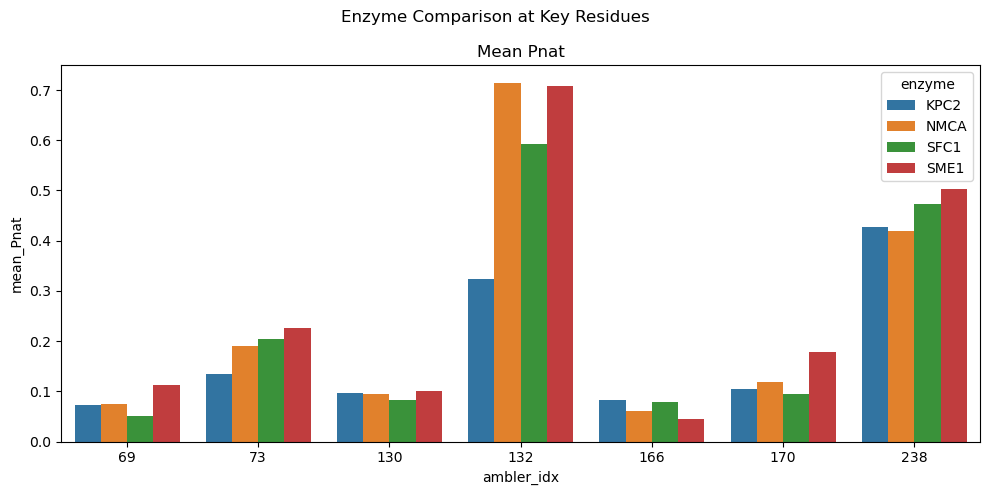

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

key_residues = [69,73,130,132,166,170,238]
plot_data = res_stats[res_stats['ambler_idx'].isin(key_residues)]

fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

sns.barplot(
    data=plot_data, x="ambler_idx", y="mean_Pnat",
    hue="enzyme", ax=axes
)
axes.set_title("Mean Pnat")


plt.suptitle("Enzyme Comparison at Key Residues")
plt.tight_layout()
plt.show()


In [4]:
res_stats.query('ambler_idx == [70,73,130,132,166,170]').sort_values(['ambler_idx', 'enzyme'])

,enzyme,ambler_idx,mean_Pnat,std_Pnat,mean_ent,std_ent,mean_gap,native_aa,native_freq,consensus_aa,consensus_freq,prop_correct
40,KPC2,70,0.062703,0.000000,2.948455,0.000000,0.001487,S,1.0,E,1.000000,0.000000
297,NMCA,70,0.062703,0.000000,2.948455,0.000000,0.001487,S,1.0,E,1.000000,0.000000
555,SFC1,70,0.062703,0.000000,2.948455,0.000000,0.001487,S,1.0,E,1.000000,0.000000
813,SME1,70,0.062703,0.000000,2.948455,0.000000,0.001487,S,1.0,E,1.000000,0.000000
43,KPC2,73,0.135097,0.107937,2.250389,0.331664,0.191853,K,1.0,R,0.597933,0.168533
300,NMCA,73,0.190230,0.134089,2.283489,0.319519,0.182924,K,1.0,R,0.487467,0.311600
558,SFC1,73,0.204756,0.149604,2.265515,0.357444,0.190099,K,1.0,R,0.455333,0.375667
816,SME1,73,0.226692,0.149185,2.213187,0.344789,0.203299,K,1.0,R,0.463933,0.398800
100,KPC2,130,0.097121,0.038585,2.161176,0.351160,0.227947,S,1.0,G,0.768933,0.043867
357,NMCA,130,0.094116,0.044450,2.207333,0.332553,0.212598,S,1.0,G,0.727600,0.060733


In [16]:
res_stats.query('ambler_idx == [69,104,105,234,235,236,237,238]').sort_values(['ambler_idx'])

,ambler_idx,mean_Pnat,std_Pnat,mean_ent,std_ent,mean_gap,native_aa,native_freq,consensus_aa,consensus_freq,prop_correct
39,69,0.077859,0.072526,1.452408,0.411700,0.517889,C,1.00,G,0.973383,0.015483
74,104,0.211219,0.225694,2.232136,0.285953,0.195076,P,0.50,P,0.720967,0.458667
75,105,0.106487,0.082207,2.274254,0.303905,0.146887,H,0.75,N,0.453383,0.093900
204,234,0.183900,0.195930,2.322995,0.339485,0.142705,K,1.00,K,0.391150,0.391150
205,235,0.111820,0.104225,2.003842,0.462669,0.213580,T,1.00,S,0.294800,0.155967
206,236,0.507802,0.282076,1.473519,0.521961,0.406762,G,1.00,G,0.719100,0.719100
207,237,0.071415,0.072484,2.247045,0.424242,0.097803,S,0.50,N,0.554333,0.076700
208,238,0.455581,0.200689,1.737491,0.346910,0.352377,C,1.00,C,0.793050,0.793050


In [6]:
# Low entropy + high P(native)
low_ent_high_p = res_stats.query('mean_ent < 0.55 and mean_Pnat > 0.7')
print("Low entropy & high P_native residues:")
low_ent_high_p[['enzyme','ambler_idx','mean_ent','mean_Pnat', 'consensus_aa', 'consensus_freq']]

Low entropy & high P_native residues:


,enzyme,ambler_idx,mean_ent,mean_Pnat,consensus_aa,consensus_freq
13,KPC2,42,0.518426,0.908814,G,0.991533
86,KPC2,116,0.470231,0.924482,G,0.999867
101,KPC2,131,0.541046,0.903896,D,0.997667
114,KPC2,144,0.515033,0.909659,G,0.992333
211,KPC2,241,0.517354,0.909944,G,0.998133
343,NMCA,116,0.469653,0.924763,G,1.000000
358,NMCA,131,0.483569,0.921453,D,1.000000
371,NMCA,144,0.518818,0.915587,G,0.999867
374,NMCA,147,0.472085,0.920384,G,0.994600
468,NMCA,241,0.546395,0.901100,G,0.996000


In [25]:
# Low entropy + low P(native)
low_ent_low_p = res_stats.query('mean_ent < 1.4 and mean_Pnat < 0.4')
print("\nLow entropy & low P_native residues:")
low_ent_low_p[['enzyme','ambler_idx','mean_ent','mean_Pnat', 'consensus_aa', 'mean_gap','consensus_freq']]#.sort_values(['mean_ent'],ascending=True)


Low entropy & low P_native residues:


,enzyme,ambler_idx,mean_ent,mean_Pnat,consensus_aa,mean_gap,consensus_freq
54,KPC2,84,1.359132,0.286202,A,0.387819,0.631600
67,KPC2,97,1.399861,0.303200,F,0.304886,0.536133
103,KPC2,133,1.299512,0.210202,T,0.404146,0.510800
152,KPC2,182,1.306901,0.384262,S,0.434653,0.443400
177,KPC2,207,1.398711,0.148736,L,0.466557,0.813667
214,KPC2,244,1.353180,0.079844,G,0.568735,0.925867
296,NMCA,69,1.364852,0.073991,G,0.576346,0.981733
360,NMCA,133,1.362228,0.363586,G,0.407463,0.497067
365,NMCA,138,1.203351,0.201339,L,0.464414,0.893400
369,NMCA,142,1.263039,0.356105,L,0.466189,0.511333


In [27]:
# Low P(native) but low std_Pnat (consistent probability)
low_p_consistent = res_stats.query('mean_Pnat < 0.3 and std_Pnat < 0.01')
print("\nLow P_native but consistent residues:")
print(low_p_consistent[['enzyme','ambler_idx','mean_Pnat','std_Pnat', 'consensus_aa', 'consensus_freq']])


Low P_native but consistent residues:
    enzyme  ambler_idx  mean_Pnat  std_Pnat consensus_aa  consensus_freq
40    KPC2          70   0.062703  0.000000            E        1.000000
297   NMCA          70   0.062703  0.000000            E        1.000000
331   NMCA         104   0.009321  0.002245            E        0.523867
392   NMCA         165   0.011682  0.008304            L        0.558000
394   NMCA         167   0.004133  0.000274            P        1.000000
429   NMCA         202   0.016010  0.006163            E        0.997067
555   SFC1          70   0.062703  0.000000            E        1.000000
650   SFC1         165   0.011842  0.007473            L        0.670867
652   SFC1         167   0.004407  0.000601            P        1.000000
686   SFC1         201   0.016565  0.004064            P        0.529533
690   SFC1         205   0.015514  0.003199            A        0.523200
738   SFC1         253   0.025125  0.008299            G        0.861733
813   SME1  

In [28]:
# High confidence gap (top - 2nd) + high P(native)
high_gap_high_p = res_stats.query('mean_gap > 0.8 and mean_Pnat > 0.8')
print("\nHigh confidence gap (top - 2nd) + high P_native residues:")
high_gap_high_p[['enzyme','ambler_idx','mean_gap','mean_Pnat','mean_ent', 'consensus_aa', 'consensus_freq']]


High confidence gap (top - 2nd) + high P_native residues:


,enzyme,ambler_idx,mean_gap,mean_Pnat,mean_ent,consensus_aa,consensus_freq
13,KPC2,42,0.901597,0.908814,0.518426,G,0.991533
86,KPC2,116,0.919390,0.924482,0.470231,G,0.999867
101,KPC2,131,0.882611,0.903896,0.541046,D,0.997667
113,KPC2,143,0.873095,0.888792,0.614400,G,0.999000
114,KPC2,144,0.901331,0.909659,0.515033,G,0.992333
166,KPC2,196,0.810828,0.836553,0.814375,G,0.993467
169,KPC2,199,0.867229,0.886017,0.606174,L,0.990200
211,KPC2,241,0.892309,0.909944,0.517354,G,0.998133
270,NMCA,42,0.887552,0.898954,0.550378,G,0.990733
343,NMCA,116,0.919890,0.924763,0.469653,G,1.000000


In [29]:
# High confidence gap (top - 2nd) + low P(native)
high_gap_low_p = res_stats.query('mean_gap > 0.4 and mean_Pnat < 0.4')
print("\nHigh confidence gap (top - 2nd) + low P_native residues:")
high_gap_low_p[['enzyme','ambler_idx','mean_gap','mean_Pnat', 'mean_ent','consensus_aa', 'consensus_freq']].sort_values(['mean_gap'],ascending=False)


High confidence gap (top - 2nd) + low P_native residues:


,enzyme,ambler_idx,mean_gap,mean_Pnat,mean_ent,consensus_aa,consensus_freq
910,SME1,167,0.914488,0.004122,0.500849,P,1.000000
394,NMCA,167,0.914080,0.004133,0.503052,P,1.000000
652,SFC1,167,0.911600,0.004407,0.514865,P,1.000000
729,SFC1,244,0.722050,0.048927,0.978371,G,0.990400
709,SFC1,224,0.694019,0.108594,0.823223,A,0.988800
451,NMCA,224,0.692643,0.093306,0.875216,A,0.952667
696,SFC1,211,0.671288,0.036741,1.118495,L,0.990933
675,SFC1,190,0.626194,0.066656,1.303080,L,0.983667
987,SME1,244,0.617017,0.092682,1.208223,G,0.955800
296,NMCA,69,0.576346,0.073991,1.364852,G,0.981733


In [30]:
# For each enzyme, pick top 5 residues by highest entropy
top5_highEnt = (
    res_stats
    .groupby('enzyme', group_keys=False)
    .apply(lambda g: g.sort_values('mean_ent', ascending=False).head(5))
    .reset_index(drop=True)
    .loc[:, ['enzyme', 'ambler_idx', 'mean_ent', 'mean_gap', 'mean_Pnat', 'consensus_aa', 'consensus_freq']]
)

# show results
for enz, grp in top5_highEnt.groupby('enzyme'):
    print(f"{enz} — top 5 (highest entropy):")
    print(grp.to_string(index=False))
    print()

KPC2 — top 5 (highest entropy):
enzyme  ambler_idx  mean_ent  mean_gap  mean_Pnat consensus_aa  consensus_freq
  KPC2          70  2.948455  0.001487   0.062703            E        1.000000
  KPC2         275  2.716449  0.032592   0.075353            D        0.497067
  KPC2          43  2.631604  0.045616   0.102846            E        0.501733
  KPC2         171  2.567340  0.075075   0.076083            H        0.282000
  KPC2         173  2.555248  0.035207   0.096091            E        0.589867

NMCA — top 5 (highest entropy):
enzyme  ambler_idx  mean_ent  mean_gap  mean_Pnat consensus_aa  consensus_freq
  NMCA          70  2.948455  0.001487   0.062703            E        1.000000
  NMCA         171  2.638761  0.053172   0.057220            K        0.291600
  NMCA          43  2.632560  0.057117   0.080018            E        0.644400
  NMCA         274  2.627807  0.074980   0.122180            P        0.358800
  NMCA          30  2.569976  0.060299   0.081448            E    

C:\Users\User\AppData\Local\Temp\ipykernel_13260\792337011.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('mean_ent', ascending=False).head(5))


In [31]:
# For each enzyme, pick top 5 residues by highest entropy
top5_highEnt = (
    res_stats
    .groupby('enzyme', group_keys=False)
    .apply(lambda g: g.sort_values('mean_gap', ascending=True).head(5))
    .reset_index(drop=True)
    .loc[:, ['enzyme', 'ambler_idx', 'mean_ent', 'mean_gap', 'mean_Pnat', 'consensus_aa', 'consensus_freq']]
)

# show results
for enz, grp in top5_highEnt.groupby('enzyme'):
    print(f"{enz} — top 5 (lowest gap):")
    print(grp.to_string(index=False))
    print()

KPC2 — top 5 (lowest gap):
enzyme  ambler_idx  mean_ent  mean_gap  mean_Pnat consensus_aa  consensus_freq
  KPC2          70  2.948455  0.001487   0.062703            E        1.000000
  KPC2         275  2.716449  0.032592   0.075353            D        0.497067
  KPC2         268  2.545011  0.032931   0.143705            E        0.339000
  KPC2         173  2.555248  0.035207   0.096091            E        0.589867
  KPC2         178  2.459884  0.043920   0.086158            D        0.333000

NMCA — top 5 (lowest gap):
enzyme  ambler_idx  mean_ent  mean_gap  mean_Pnat consensus_aa  consensus_freq
  NMCA          70  2.948455  0.001487   0.062703            E        1.000000
  NMCA         282  2.341325  0.037755   0.187404            R        0.408533
  NMCA         114  2.490152  0.038912   0.135541            E        0.369200
  NMCA         173  2.516178  0.040344   0.094012            E        0.529733
  NMCA         275  2.495386  0.042120   0.069818            E        0.7474

C:\Users\User\AppData\Local\Temp\ipykernel_13260\3995018423.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('mean_gap', ascending=True).head(5))


In [32]:
pivot = res_stats.pivot(index='ambler_idx', columns='enzyme', values='mean_Pnat')
consensus = pivot.mean(axis=1)
divergence = pivot.std(axis=1)

In [34]:
# Top 10 consensus Pnative positions
top_consensus = consensus.sort_values(ascending=False).head(10)
print("\nTop 10 consensus P_native (across enzymes):")
print(top_consensus)

# Bottom 10 consensus Pnative positions
bottom_consensus = consensus.sort_values().head(10)
print("\nBottom 10 consensus P_native (across enzymes):")
print(bottom_consensus)


Top 10 consensus P_native (across enzymes):
ambler_idx
116    0.920903
131    0.914561
144    0.910768
42     0.903020
241    0.902463
196    0.859494
199    0.842945
156    0.839152
147    0.832381
143    0.820117
dtype: float64

Bottom 10 consensus P_native (across enzymes):
ambler_idx
233    0.011760
165    0.013854
189    0.035512
71     0.039801
230    0.043336
246    0.046076
219    0.051684
167    0.052921
177    0.055803
191    0.056769
dtype: float64


In [ ]:

# High divergence positions
high_divergence = divergence.sort_values(ascending=False).head(10)
print("\nTop 10 divergent positions (mean_Pnative):")
print(high_divergence)

# Low divergence positions
low_divergence = divergence.sort_values().head(10)
print("\nTop 10 low divergence positions (mean_Pnative):")
print(low_divergence)



Top 10 divergent positions (mean_Pnative):
ambler_idx
54     0.363815
122    0.354049
224    0.348717
91     0.345905
138    0.335308
41     0.332877
36     0.325373
136    0.312883
273    0.310230
123    0.301826
dtype: float64

Top 10 low divergence positions (mean_Pnative):
ambler_idx
70     0.000000
165    0.002421
39     0.003086
233    0.004318
178    0.004480
173    0.005132
189    0.005870
129    0.006320
144    0.006349
130    0.007061
dtype: float64


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Aggregate across enzymes (per Ambler position)
metrics_cross = (
    res_stats.groupby('ambler_idx')
        .agg(
            avg_Pnat        = ('mean_Pnat',     'mean'),
            avg_gap         = ('mean_gap',      'mean'),
            avg_ent         = ('mean_ent',      'mean'),
            avg_cons_freq   = ('consensus_freq','mean'),
            Pnat_div        = ('mean_Pnat',     'std'),
            gap_div         = ('mean_gap',      'std'),
            ent_div         = ('mean_ent',      'std'),
            cf_div          = ('consensus_freq','std'),
            consensus_aa    = ('consensus_aa',  lambda x: x.mode()[0]),
            avg_prop_correct = ('prop_correct','mean'),
            native_aa      = ('native_aa',     lambda x: x.mode()[0]),
            native_freq    = ('native_aa',    lambda x: x.value_counts(normalize=True).iloc[0])
        )
        .reset_index()
)

# For each ambler_idx, count how many enzymes chose that consensus_aa
agreement = (
    res_stats
    .groupby('ambler_idx')['consensus_aa']
    .agg(agreement_count=lambda x: x.value_counts().iloc[0])
    .reset_index()
)

# Merge back into your metrics_cross
metrics_cross = metrics_cross.merge(agreement, on='ambler_idx', how='left')

n_enz = res_stats['enzyme'].nunique()  # should be 4
metrics_cross['agreement_frac'] = metrics_cross['agreement_count'] / n_enz

# Scale metrics into [0,1]
scaler = MinMaxScaler()
to_scale = [
    'avg_Pnat','avg_gap','avg_ent','avg_cons_freq',
    'Pnat_div','gap_div','ent_div','cf_div', 'avg_prop_correct'
]
scaled = scaler.fit_transform(metrics_cross[to_scale])
metrics_cross[[f"{c}_s" for c in to_scale]] = scaled

# Composite importance score (equal weights)
metrics_cross['composite_score'] = (
    2*(1-metrics_cross['avg_Pnat_s']) + (metrics_cross['avg_gap_s']) +
    0.5*(metrics_cross['avg_cons_freq_s']) + 0.5*(1-metrics_cross['avg_ent_s']) +
    2*(1-metrics_cross['avg_prop_correct_s'])
) / len(to_scale)

# Extract top positions
top_positions = metrics_cross.sort_values(
    'composite_score', ascending=False
).head(25)[[
    'ambler_idx','native_aa', 'native_freq','consensus_aa','agreement_frac','avg_Pnat', 'avg_prop_correct','avg_gap','avg_ent',
    'avg_cons_freq','Pnat_div','gap_div','ent_div','cf_div','composite_score'
]]

top_positions



,ambler_idx,native_aa,native_freq,consensus_aa,agreement_frac,avg_Pnat,avg_prop_correct,avg_gap,avg_ent,avg_cons_freq,Pnat_div,gap_div,ent_div,cf_div,composite_score
137,167,L,1.00,P,0.75,0.052921,0.069567,0.727711,0.920860,0.859033,0.097401,0.371359,0.829232,0.281933,0.597268
214,244,N,1.00,G,1.00,0.067833,0.027417,0.615807,1.239484,0.948550,0.021921,0.075610,0.194945,0.031709,0.589274
39,69,C,1.00,G,1.00,0.077859,0.015483,0.517889,1.452408,0.973383,0.025824,0.049427,0.108970,0.010826,0.574739
167,197,N,0.75,D,1.00,0.099201,0.000083,0.293537,1.934755,0.942050,0.018455,0.024960,0.019162,0.034785,0.532355
159,189,S,1.00,L,1.00,0.035512,0.001633,0.274109,1.987823,0.629350,0.005870,0.042018,0.066216,0.110603,0.519397
69,99,K,0.25,D,0.50,0.096033,0.008017,0.206350,2.133738,0.864550,0.036737,0.172359,0.423848,0.129543,0.510187
203,233,D,1.00,Y,0.50,0.011760,0.000267,0.269584,1.835191,0.359583,0.004318,0.032058,0.154125,0.035083,0.507147
57,87,Q,0.50,E,0.50,0.097137,0.026350,0.282875,1.968837,0.714583,0.024591,0.214618,0.491067,0.263595,0.507042
172,202,H,0.25,E,1.00,0.070292,0.037650,0.155705,2.349485,0.952117,0.049627,0.039143,0.080039,0.068847,0.505774
41,71,S,1.00,L,0.75,0.039801,0.027283,0.241490,2.043785,0.586100,0.021935,0.120849,0.309241,0.151123,0.504015


In [47]:
res_stats.query('ambler_idx == [189]').sort_values(['ambler_idx', 'enzyme'])

,enzyme,ambler_idx,mean_Pnat,std_Pnat,mean_ent,std_ent,mean_gap,native_aa,native_freq,consensus_aa,consensus_freq,prop_correct
159,KPC2,189,0.039864,0.044449,1.974070,0.328682,0.280263,S,1.0,L,0.586667,0.005200
416,NMCA,189,0.028191,0.023319,1.901815,0.352662,0.330682,S,1.0,L,0.794000,0.000267
674,SFC1,189,0.040631,0.026704,2.054892,0.290309,0.236012,S,1.0,L,0.581200,0.000933
932,SME1,189,0.033363,0.022967,2.020515,0.278207,0.249478,S,1.0,L,0.555533,0.000133


---------------